**The Start Of It All...**

# Libraries

In [1]:
#Change the width of the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#Standard Libraries
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import random
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
#User counter to check frequencies (https://pymotw.com/2/collections/counter.html)
from  collections import Counter

In [3]:
#Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from pandas.plotting import scatter_matrix
import seaborn as sns
# Pretty display for notebooks
%matplotlib inline
# Import supplementary visualizations code visuals.py
import visuals as vs

In [4]:
#Modelling Libraries
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import tree
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

# Data

In [5]:
sampleMode = 1

In [6]:
if sampleMode == 1:
    file = "sample_model_data_protected_small5k.csv"
else:
    file = "sample_model_data_protected_60k.csv"
# Load Company IP Intent Data (March Sample)
try:
    full_data = pd.read_csv(file)
    print("Company IP Intent dataset has {} samples with {} features each.".format(*full_data.shape))
except:
    print("Dataset could not be loaded!")

print("Do not use excel UTF-8 format for csv, it breaks stuff...")

Company IP Intent dataset has 58724 samples with 40 features each.
Do not use excel UTF-8 format for csv, it breaks stuff...


## Take a random sample for modelling due to size

In [7]:
def getRandomIDXs(n,d):
    N=len(d)
    indices=[]
    for i in range(0, n):
        randomInt = (random.randint(0, N))
        if randomInt not in indices:
            indices.append(randomInt)
    print("Sample indices selected - ", str(len(indices)))
    return indices

def getRandomSample(n,d):
    N=len(d)
    n=round(n*N)
    indices = getRandomIDXs(n,d)
    sample = pd.DataFrame(d.reindex(indices), columns = d.keys()).reset_index(drop = True)
    #sample = pd.DataFrame(d.loc[indices], columns = d.keys()).reset_index(drop = True)
    print(sample.shape)
    return sample

In [8]:
#Take a sample due to the size of the dataset here
data = getRandomSample(1.0,full_data)
#data = full_data
print("Chosen samples of Company Intent customers dataset:",str(len(data)))
data[:3]

Sample indices selected -  37081
(37081, 40)
Chosen samples of Company Intent customers dataset: 37081


acct_id              city    region countryCode  revenue_mil_usd  \
0  4-1NC3-403271         Henderson    Nevada          US           6.2815   
1  4-1NB0-385424          Fribourg  Fribourg          CH       29573.9900   
2  4-1NBU-402113  Farmington Hills  Michigan          US          29.0899   

   total_employees usageType  datesCount  domainsCount  hitsSum  ...  \
0             50.0       COM        29.0          45.0    132.0  ...   
1          87414.0       COM        23.0          61.0    619.0  ...   
2            212.0       NaN        13.0          37.0     92.0  ...   

   hits_iabCat_IAB_17  hits_iabCat_IAB_18  hits_iabCat_IAB_19  \
0                 2.0                 8.0                32.0   
1                 1.0                 1.0                94.0   
2                 0.0                 7.0                26.0   

   hits_iabCat_IAB_20  hits_iabCat_IAB_21  hits_iabCat_IAB_22  \
0                 0.0                 3.0                 4.0   
1                 2.0                 0.0                61.0   
2                 0.0                 6.0                 0.0   

   hits_iabCat_IAB_23  hits_iabCat_IAB_24  hits_iabCat_IAB_25  \
0                 0.0                22.0                 0.0   
1                 3.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   

   hits_iabCat_IAB_26  
0                 0.0  
1                 2.0  
2                 0.0  

[3 rows x 40 columns]

In [9]:
data.dtypes

acct_id                object
city                   object
region                 object
countryCode            object
revenue_mil_usd       float64
total_employees       float64
usageType              object
datesCount            float64
domainsCount          float64
hitsSum               float64
pageViewsSum          float64
uniqueViewsSum        float64
clicks                float64
clickDates            float64
hits_iabCat_IAB_1     float64
hits_iabCat_IAB_2     float64
hits_iabCat_IAB_3     float64
hits_iabCat_IAB_4     float64
hits_iabCat_IAB_5     float64
hits_iabCat_IAB_6     float64
hits_iabCat_IAB_7     float64
hits_iabCat_IAB_8     float64
hits_iabCat_IAB_9     float64
hits_iabCat_IAB_10    float64
hits_iabCat_IAB_11    float64
hits_iabCat_IAB_12    float64
hits_iabCat_IAB_13    float64
hits_iabCat_IAB_14    float64
hits_iabCat_IAB_15    float64
hits_iabCat_IAB_16    float64
hits_iabCat_IAB_17    float64
hits_iabCat_IAB_18    float64
hits_iabCat_IAB_19    float64
hits_iabCa

In [10]:
#Null fill values to prevent NaN issues
def zeroFillColumn(d):
    cols = d.columns
    for col in cols:
        if is_numeric_dtype(d[col]):
            d[col].fillna(0, inplace = True)
        else:
            d[col].fillna("Unknown", inplace = True)
    return d
data = zeroFillColumn(data)

# Data Exploration
In this sections I will attempt to find correlations in my data with summary statistics and visualations to help guide the supervised learning

### Investigate the Reliability of the Columns
This dataset has been derived from a production system which may have too sparse datapoints for  certain metrics OR just too unreliable due to poor matching between disparate datasets

Flag and remove early on for performance reasons mainly

In [11]:
# Display a description of the dataset
t=data.describe()
t.to_csv('summary_statistics.csv')
data.describe()

revenue_mil_usd  total_employees    datesCount  domainsCount  \
count     3.708100e+04     3.708100e+04  37081.000000  37081.000000   
mean      1.483278e+04     1.561685e+04     13.869718     71.732397   
std       6.076375e+05     5.865738e+04      9.883422    192.290394   
min       0.000000e+00     0.000000e+00      0.000000      0.000000   
25%       9.230800e+00     6.400000e+01      5.000000      5.000000   
50%       4.986118e+01     2.690000e+02     12.000000     17.000000   
75%       4.412786e+02     2.300000e+03     22.000000     58.000000   
max       1.100000e+08     2.768886e+06     31.000000   6230.000000   

             hitsSum   pageViewsSum  uniqueViewsSum        clicks  \
count   37081.000000   37081.000000    37081.000000  37081.000000   
mean      679.030393    2253.522990     1016.804374      0.310375   
std      4437.157559   15742.690387     6630.372029     38.616177   
min         0.000000       0.000000        0.000000      0.000000   
25%        11.000000      20.000000       14.000000      0.000000   
50%        50.000000     120.000000       74.000000      0.000000   
75%       231.000000     624.000000      343.000000      0.000000   
max    293812.000000  868332.000000   406915.000000   6748.000000   

         clickDates  hits_iabCat_IAB_1  ...  hits_iabCat_IAB_17  \
count  37081.000000       37081.000000  ...        37081.000000   
mean       0.024649          39.534236  ...           15.483563   
std        0.336292         272.310937  ...           96.100994   
min        0.000000           0.000000  ...            0.000000   
25%        0.000000           0.000000  ...            0.000000   
50%        0.000000           2.000000  ...            1.000000   
75%        0.000000          12.000000  ...            5.000000   
max       31.000000       19317.000000  ...         5344.000000   

       hits_iabCat_IAB_18  hits_iabCat_IAB_19  hits_iabCat_IAB_20  \
count        37081.000000        37081.000000        37081.000000   
mean            14.711308          152.273860            1.361641   
std            101.764094         1015.322386           10.250790   
min              0.000000            0.000000            0.000000   
25%              0.000000            1.000000            0.000000   
50%              1.000000            9.000000            0.000000   
75%              5.000000           51.000000            0.000000   
max           6362.000000        69477.000000          633.000000   

       hits_iabCat_IAB_21  hits_iabCat_IAB_22  hits_iabCat_IAB_23  \
count        37081.000000        37081.000000        37081.000000   
mean             8.529705           48.516194            0.310051   
std             88.124837          360.052709            2.398930   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              2.000000            8.000000            0.000000   
max           9027.000000        22593.000000          143.000000   

       hits_iabCat_IAB_24  hits_iabCat_IAB_25  hits_iabCat_IAB_26  
count        37081.000000        37081.000000        37081.000000  
mean             4.632238            0.000216            3.815027  
std             29.268692            0.014687           28.400159  
min              0.000000            0.000000            0.000000  
25%              0.000000            0.000000            0.000000  
50%              0.000000            0.000000            0.000000  
75%              1.000000            0.000000            0.000000  
max           1946.000000            1.000000         1702.000000  

[8 rows x 35 columns]

- Ignore NAICS codes.

- hitsSum/pageViewsSum/uniqueViewsSum/most of the iabCat hits - Massively varying between accounts. Highlighy right skewed, with the std way over the 75th percentile
- Alot of iabCat hits with 0 as the values for everything below the 75th percentile. Likely needs to be removed from the dataset as no significant inferences can be made if only a few companies have hits for the certain categories

In [12]:
#Group columns together for analysis
iabCat_hits_cols = [col for col in data.columns if 'hits_iabCat' in col]
summaryMetricCols = ['datesCount', 'domainsCount', 'hitsSum','pageViewsSum', 'uniqueViewsSum', 'clicks', 'clickDates']
labelCols = ['acct_id','hq_id','company','userDomain','city','region','countryCode','revenue_mil_usd','total_employees']
coninuousCols = iabCat_hits_cols + summaryMetricCols + ['revenue_mil_usd','total_employees']

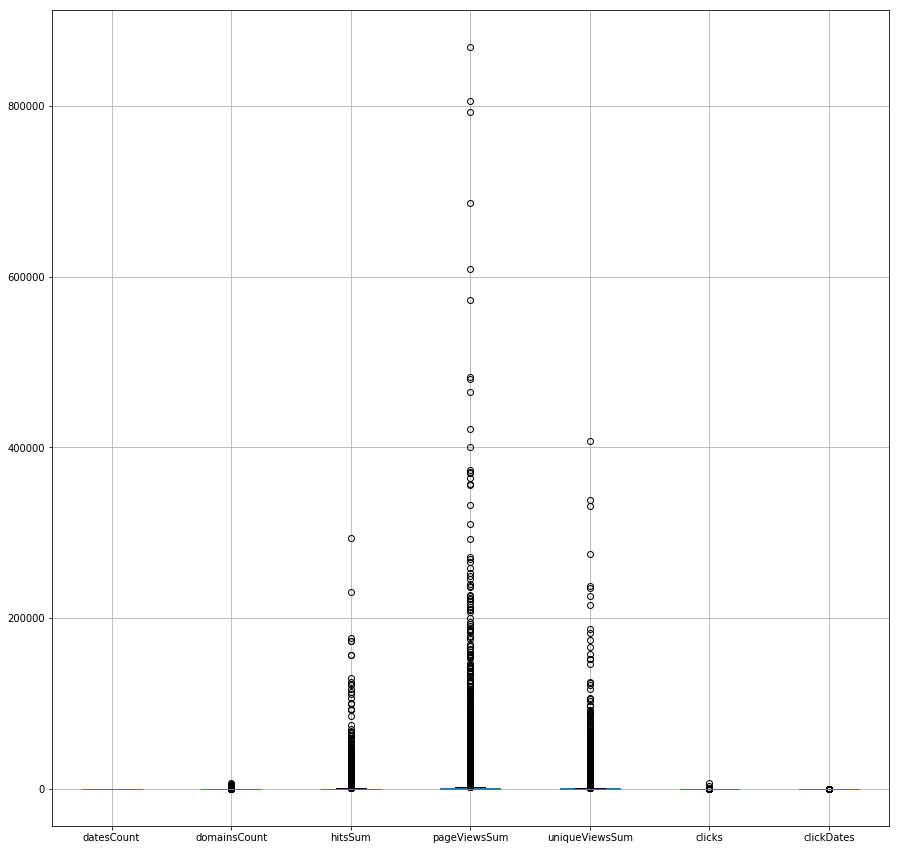

In [13]:
boxplot = data.boxplot(column=summaryMetricCols,figsize=(15,15))

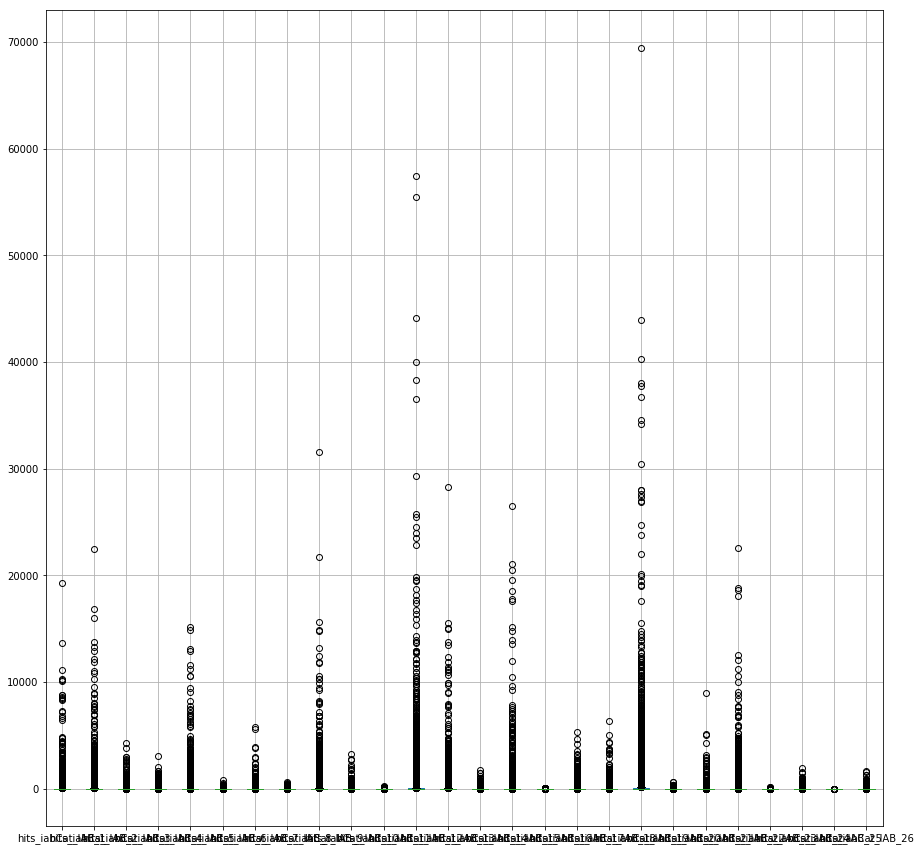

In [14]:
boxplot = data.boxplot(column=iabCat_hits_cols,figsize=(15,15))

### Remove outlier columns early on

In [15]:
#Get Outliers IDXs per feature column
def getOutLierIDXs(d):
    #Intialise counters
    outliers = []
    featureDict = {}
    typeDict = data.columns.to_series().groupby(data.dtypes).groups
    # For each feature find the data points with extreme high or low values
    for feature in d.keys():
        #Break early if not a number value
        if is_numeric_dtype(d[feature]):
            #Calculate Q1 (25th percentile of the data) for the given feature
            Q1 = np.percentile(d[feature],25)
            #Calculate Q3 (75th percentile of the data) for the given feature
            Q3 = np.percentile(d[feature],75)
            #Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
            step = (Q3 - Q1)*1.5
            #Outlier if value step below lower quartile OR step above upper quartile
            featureOutliers = d[(d[feature] <= Q1 - step) | (d[feature] >= Q3 + step)]
            outlierIDXs = featureOutliers.index.tolist()
            featureDict[feature] = len(featureOutliers)
            print("Number of outliers detected for feature - " + str(feature) + " = " +str(len(featureOutliers)))
            #Add to global list of outliersIDXs
            outliers.extend(outlierIDXs)
    return (outliers,featureDict)

In [16]:
#Remove any columns where all values are classed as outulier, a good few iabCat columns
res = getOutLierIDXs(data)
outliers = res[0]
featureDict = res[1]

#Clean dataset
datac = data.copy()
badBoys = []
for feature in featureDict.keys():
    if (featureDict[feature]) == len(datac):
        badBoys.append(feature)
        print(str(feature) + "- Feature added to blacklist")
#Drop Bad columns
for feature in badBoys:
    datac.drop([feature], axis = 1, inplace = True)

Number of outliers detected for feature - revenue_mil_usd = 6727
Number of outliers detected for feature - total_employees = 6606
Number of outliers detected for feature - datesCount = 0
Number of outliers detected for feature - domainsCount = 4450
Number of outliers detected for feature - hitsSum = 5277
Number of outliers detected for feature - pageViewsSum = 5474
Number of outliers detected for feature - uniqueViewsSum = 5243
Number of outliers detected for feature - clicks = 37081
Number of outliers detected for feature - clickDates = 37081
Number of outliers detected for feature - hits_iabCat_IAB_1 = 5421
Number of outliers detected for feature - hits_iabCat_IAB_2 = 5302
Number of outliers detected for feature - hits_iabCat_IAB_3 = 7376
Number of outliers detected for feature - hits_iabCat_IAB_4 = 7168
Number of outliers detected for feature - hits_iabCat_IAB_5 = 6212
Number of outliers detected for feature - hits_iabCat_IAB_6 = 37081
Number of outliers detected for feature - hits_

In [17]:
#Remove outlier function
def getMultiClassOutliers(d):
    #Get outlier indexes per column
    res = getOutLierIDXs(d)
    outliers = res[0]
    featureDict = res[1]
    #Capture multi-feature outliers
    multiOutliers=[]
    countsDict = dict(Counter(outliers))
    for idx in list(countsDict.keys()):
        if countsDict[idx] > 1:
            multiOutliers.append(idx)
            print('Multi-Feature outlier found at index = ' + str(idx))
    print('Total multi-Feature outliers found = ' + str(len(multiOutliers)) + ' out of sample of ' + str(len(d)))
    return multiOutliers

In [18]:
#Re-run outlier detection and remove multi-feature outliers
outliersN = getMultiClassOutliers(datac)

Number of outliers detected for feature - revenue_mil_usd = 6727
Number of outliers detected for feature - total_employees = 6606
Number of outliers detected for feature - datesCount = 0
Number of outliers detected for feature - domainsCount = 4450
Number of outliers detected for feature - hitsSum = 5277
Number of outliers detected for feature - pageViewsSum = 5474
Number of outliers detected for feature - uniqueViewsSum = 5243
Number of outliers detected for feature - hits_iabCat_IAB_1 = 5421
Number of outliers detected for feature - hits_iabCat_IAB_2 = 5302
Number of outliers detected for feature - hits_iabCat_IAB_3 = 7376
Number of outliers detected for feature - hits_iabCat_IAB_4 = 7168
Number of outliers detected for feature - hits_iabCat_IAB_5 = 6212
Number of outliers detected for feature - hits_iabCat_IAB_7 = 5120
Number of outliers detected for feature - hits_iabCat_IAB_9 = 5574
Number of outliers detected for feature - hits_iabCat_IAB_10 = 4854
Number of outliers detected for

Multi-Feature outlier found at index = 7987
Multi-Feature outlier found at index = 7989
Multi-Feature outlier found at index = 7991
Multi-Feature outlier found at index = 7999
Multi-Feature outlier found at index = 8016
Multi-Feature outlier found at index = 8022
Multi-Feature outlier found at index = 8024
Multi-Feature outlier found at index = 8026
Multi-Feature outlier found at index = 8029
Multi-Feature outlier found at index = 8040
Multi-Feature outlier found at index = 8044
Multi-Feature outlier found at index = 8050
Multi-Feature outlier found at index = 8052
Multi-Feature outlier found at index = 8060
Multi-Feature outlier found at index = 8062
Multi-Feature outlier found at index = 8085
Multi-Feature outlier found at index = 8107
Multi-Feature outlier found at index = 8115
Multi-Feature outlier found at index = 8118
Multi-Feature outlier found at index = 8122
Multi-Feature outlier found at index = 8126
Multi-Feature outlier found at index = 8128
Multi-Feature outlier found at i

Multi-Feature outlier found at index = 17098
Multi-Feature outlier found at index = 17102
Multi-Feature outlier found at index = 17103
Multi-Feature outlier found at index = 17109
Multi-Feature outlier found at index = 17112
Multi-Feature outlier found at index = 17116
Multi-Feature outlier found at index = 17121
Multi-Feature outlier found at index = 17123
Multi-Feature outlier found at index = 17137
Multi-Feature outlier found at index = 17140
Multi-Feature outlier found at index = 17144
Multi-Feature outlier found at index = 17149
Multi-Feature outlier found at index = 17155
Multi-Feature outlier found at index = 17184
Multi-Feature outlier found at index = 17200
Multi-Feature outlier found at index = 17213
Multi-Feature outlier found at index = 17218
Multi-Feature outlier found at index = 17219
Multi-Feature outlier found at index = 17229
Multi-Feature outlier found at index = 17232
Multi-Feature outlier found at index = 17241
Multi-Feature outlier found at index = 17244
Multi-Feat

Multi-Feature outlier found at index = 29557
Multi-Feature outlier found at index = 29560
Multi-Feature outlier found at index = 29569
Multi-Feature outlier found at index = 29571
Multi-Feature outlier found at index = 29572
Multi-Feature outlier found at index = 29573
Multi-Feature outlier found at index = 29588
Multi-Feature outlier found at index = 29609
Multi-Feature outlier found at index = 29618
Multi-Feature outlier found at index = 29624
Multi-Feature outlier found at index = 29636
Multi-Feature outlier found at index = 29646
Multi-Feature outlier found at index = 29655
Multi-Feature outlier found at index = 29658
Multi-Feature outlier found at index = 29677
Multi-Feature outlier found at index = 29678
Multi-Feature outlier found at index = 29686
Multi-Feature outlier found at index = 29690
Multi-Feature outlier found at index = 29692
Multi-Feature outlier found at index = 29700
Multi-Feature outlier found at index = 29711
Multi-Feature outlier found at index = 29714
Multi-Feat

Multi-Feature outlier found at index = 15444
Multi-Feature outlier found at index = 15471
Multi-Feature outlier found at index = 15477
Multi-Feature outlier found at index = 15478
Multi-Feature outlier found at index = 15514
Multi-Feature outlier found at index = 15622
Multi-Feature outlier found at index = 15632
Multi-Feature outlier found at index = 15788
Multi-Feature outlier found at index = 15833
Multi-Feature outlier found at index = 15885
Multi-Feature outlier found at index = 16045
Multi-Feature outlier found at index = 16223
Multi-Feature outlier found at index = 16271
Multi-Feature outlier found at index = 16297
Multi-Feature outlier found at index = 16354
Multi-Feature outlier found at index = 16365
Multi-Feature outlier found at index = 16576
Multi-Feature outlier found at index = 16615
Multi-Feature outlier found at index = 16700
Multi-Feature outlier found at index = 16727
Multi-Feature outlier found at index = 16772
Multi-Feature outlier found at index = 16786
Multi-Feat

Multi-Feature outlier found at index = 12493
Multi-Feature outlier found at index = 12504
Multi-Feature outlier found at index = 12506
Multi-Feature outlier found at index = 12523
Multi-Feature outlier found at index = 12539
Multi-Feature outlier found at index = 12540
Multi-Feature outlier found at index = 12560
Multi-Feature outlier found at index = 12562
Multi-Feature outlier found at index = 12571
Multi-Feature outlier found at index = 12582
Multi-Feature outlier found at index = 12596
Multi-Feature outlier found at index = 12605
Multi-Feature outlier found at index = 12609
Multi-Feature outlier found at index = 12614
Multi-Feature outlier found at index = 12616
Multi-Feature outlier found at index = 12628
Multi-Feature outlier found at index = 12641
Multi-Feature outlier found at index = 12664
Multi-Feature outlier found at index = 12710
Multi-Feature outlier found at index = 12715
Multi-Feature outlier found at index = 12718
Multi-Feature outlier found at index = 12738
Multi-Feat

Multi-Feature outlier found at index = 29974
Multi-Feature outlier found at index = 29980
Multi-Feature outlier found at index = 29984
Multi-Feature outlier found at index = 29985
Multi-Feature outlier found at index = 30010
Multi-Feature outlier found at index = 30012
Multi-Feature outlier found at index = 30022
Multi-Feature outlier found at index = 30028
Multi-Feature outlier found at index = 30054
Multi-Feature outlier found at index = 30060
Multi-Feature outlier found at index = 30066
Multi-Feature outlier found at index = 30067
Multi-Feature outlier found at index = 30093
Multi-Feature outlier found at index = 30105
Multi-Feature outlier found at index = 30137
Multi-Feature outlier found at index = 30163
Multi-Feature outlier found at index = 30169
Multi-Feature outlier found at index = 30171
Multi-Feature outlier found at index = 30172
Multi-Feature outlier found at index = 30181
Multi-Feature outlier found at index = 30189
Multi-Feature outlier found at index = 30204
Multi-Feat

Multi-Feature outlier found at index = 3597
Multi-Feature outlier found at index = 3619
Multi-Feature outlier found at index = 3626
Multi-Feature outlier found at index = 3640
Multi-Feature outlier found at index = 3671
Multi-Feature outlier found at index = 3750
Multi-Feature outlier found at index = 3772
Multi-Feature outlier found at index = 3789
Multi-Feature outlier found at index = 4044
Multi-Feature outlier found at index = 4048
Multi-Feature outlier found at index = 4129
Multi-Feature outlier found at index = 4133
Multi-Feature outlier found at index = 4161
Multi-Feature outlier found at index = 4210
Multi-Feature outlier found at index = 4337
Multi-Feature outlier found at index = 4379
Multi-Feature outlier found at index = 4413
Multi-Feature outlier found at index = 4416
Multi-Feature outlier found at index = 4503
Multi-Feature outlier found at index = 4635
Multi-Feature outlier found at index = 4666
Multi-Feature outlier found at index = 4823
Multi-Feature outlier found at i

Multi-Feature outlier found at index = 35417
Multi-Feature outlier found at index = 35432
Multi-Feature outlier found at index = 35819
Multi-Feature outlier found at index = 35854
Multi-Feature outlier found at index = 35915
Multi-Feature outlier found at index = 36056
Multi-Feature outlier found at index = 36062
Multi-Feature outlier found at index = 36120
Multi-Feature outlier found at index = 36123
Multi-Feature outlier found at index = 36185
Multi-Feature outlier found at index = 36199
Multi-Feature outlier found at index = 36211
Multi-Feature outlier found at index = 36256
Multi-Feature outlier found at index = 36274
Multi-Feature outlier found at index = 36319
Multi-Feature outlier found at index = 36362
Multi-Feature outlier found at index = 36392
Multi-Feature outlier found at index = 36591
Multi-Feature outlier found at index = 36667
Multi-Feature outlier found at index = 36679
Multi-Feature outlier found at index = 36727
Multi-Feature outlier found at index = 36791
Multi-Feat

Multi-Feature outlier found at index = 11073
Multi-Feature outlier found at index = 11103
Multi-Feature outlier found at index = 11117
Multi-Feature outlier found at index = 11147
Multi-Feature outlier found at index = 11158
Multi-Feature outlier found at index = 11165
Multi-Feature outlier found at index = 11166
Multi-Feature outlier found at index = 11215
Multi-Feature outlier found at index = 11227
Multi-Feature outlier found at index = 11271
Multi-Feature outlier found at index = 11422
Multi-Feature outlier found at index = 11459
Multi-Feature outlier found at index = 11466
Multi-Feature outlier found at index = 11469
Multi-Feature outlier found at index = 11494
Multi-Feature outlier found at index = 11522
Multi-Feature outlier found at index = 11540
Multi-Feature outlier found at index = 11545
Multi-Feature outlier found at index = 11555
Multi-Feature outlier found at index = 11576
Multi-Feature outlier found at index = 11593
Multi-Feature outlier found at index = 11625
Multi-Feat

Multi-Feature outlier found at index = 26161
Multi-Feature outlier found at index = 26184
Multi-Feature outlier found at index = 26213
Multi-Feature outlier found at index = 26520
Multi-Feature outlier found at index = 26636
Multi-Feature outlier found at index = 26689
Multi-Feature outlier found at index = 26719
Multi-Feature outlier found at index = 26736
Multi-Feature outlier found at index = 26783
Multi-Feature outlier found at index = 26939
Multi-Feature outlier found at index = 26943
Multi-Feature outlier found at index = 26965
Multi-Feature outlier found at index = 26984
Multi-Feature outlier found at index = 27024
Multi-Feature outlier found at index = 27084
Multi-Feature outlier found at index = 27089
Multi-Feature outlier found at index = 27093
Multi-Feature outlier found at index = 27099
Multi-Feature outlier found at index = 27134
Multi-Feature outlier found at index = 27165
Multi-Feature outlier found at index = 27180
Multi-Feature outlier found at index = 27242
Multi-Feat

Multi-Feature outlier found at index = 10964
Multi-Feature outlier found at index = 11200
Multi-Feature outlier found at index = 11731
Multi-Feature outlier found at index = 11951
Multi-Feature outlier found at index = 12251
Multi-Feature outlier found at index = 12346
Multi-Feature outlier found at index = 12367
Multi-Feature outlier found at index = 12468
Multi-Feature outlier found at index = 12880
Multi-Feature outlier found at index = 13041
Multi-Feature outlier found at index = 13312
Multi-Feature outlier found at index = 13613
Multi-Feature outlier found at index = 13645
Multi-Feature outlier found at index = 13995
Multi-Feature outlier found at index = 14048
Multi-Feature outlier found at index = 14628
Multi-Feature outlier found at index = 15356
Multi-Feature outlier found at index = 15378
Multi-Feature outlier found at index = 15515
Multi-Feature outlier found at index = 15560
Multi-Feature outlier found at index = 15577
Multi-Feature outlier found at index = 15690
Multi-Feat

In [19]:
#Remove outliers
print('Total outliers detected = '+str(len(outliersN)) + ' out of a total sample of ' + str(len(datac)))
good_data = datac.drop(datac.index[outliersN]).reset_index(drop = True)
print('Muli-class outliers removed, and noisey columns removed. Remaining rows = {}, remaining columns = {}'.format(*good_data.shape))

Total outliers detected = 15758 out of a total sample of 37081
Muli-class outliers removed, and noisey columns removed. Remaining rows = 21323, remaining columns = 30


In [20]:
#Reset Metric Columns after blacklisting
iabCat_hits_cols = [col for col in good_data.columns if 'hits_iabCat' in col]
summary_metric_cols = ['datesCount', 'domainsCount', 'hitsSum','pageViewsSum', 'uniqueViewsSum', 'clicks', 'clickDates']
label_cols = ['acct_id','hq_id','company','userDomain','city','region','countryCode','revenue_mil_usd','total_employees']
continuous_cols = iabCat_hits_cols + ['revenue_mil_usd','total_employees']

#Ensure only columns still remaining
current_cols = good_data.columns
iabCat_hits_cols = sorted(list(set(iabCat_hits_cols) & set(current_cols)))
summary_metric_cols = list(set(summary_metric_cols) & set(current_cols))
label_cols = list(set(label_cols) & set(current_cols))
continuous_cols = sorted(list(set(continuous_cols) & set(current_cols)))

###  Random Sample Analysis
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail.

In [21]:
#Generate random samples to investigate quickly and visually
portion=0.005
samples = getRandomSample(portion,good_data)
sample_size=len(samples)
print("Chosen samples of Company Intent customers dataset:")
display(samples)

#Visualise Sample data
samples_for_plot = samples.copy()
samples_for_plot = samples_for_plot[summary_metric_cols]
#Add median plot as well
columnsN = len(samples_for_plot.columns)
samples_for_plot.loc[sample_size + 1] = good_data.median()
#Create lables
labels=[]
for i in range(0,sample_size):
    name = 'Sample_'+str(i)
    labels.append(name)    

labels.append('Median') 

Sample indices selected -  107
(107, 30)
Chosen samples of Company Intent customers dataset:


acct_id            city               region countryCode  \
0     4-1NBX-83985  Cape Girardeau             Missouri          US   
1    4-1NBO-323168         Chicago             Illinois          US   
2    4-1NCF-259526     San Antonio                Texas          US   
3    4-1NBI-322330      Ridgefield          Connecticut          US   
4    4-1NC9-471044       Nashville            Tennessee          US   
5    4-1NBR-640919       Broussard            Louisiana          US   
6    4-1NC6-190675    Broken Arrow             Oklahoma          US   
7    4-1NBL-645502        Savannah              Georgia          US   
8    4-1NCC-127918           Plano                Texas          US   
9    4-1NBI-584420       Homestead              Florida          US   
10   4-1NCC-551477         Brenham                Texas          US   
11   4-1NAU-402585          Ushiku              Ibaraki          JP   
12   4-1NCI-126934         Tukwila           Washington          US   
13   4-1NCF-264777        Comanche                Texas          US   
14    4-1NB9-42535      Long Beach           California          US   
15   4-1NAU-373997         Bolzano  Trentino-Alto Adige          IT   
16   4-1NC6-599831     Garden City             New York          US   
17   4-1NBF-265604         Greeley             Colorado          US   
18   4-1NBL-179267        Meridian                Idaho          US   
19   4-1NB9-634217            Helm           California          US   
20    4-1NB0-80487    Sankt Gallen         Sankt Gallen          CH   
21    4-1NB9-13817          Corona           California          US   
22   4-1NAX-642000           Aarau               Aargau          CH   
23   4-1NB6-563157   San Francisco           California          US   
24   4-1NBU-418166      Grandville             Michigan          US   
25   4-1NBI-195111       Pensacola              Florida          US   
26   4-1NCC-578067           Plano                Texas          US   
27    4-1NAU-96840           Tokyo                Tokyo          JP   
28     4-1NBR-5330        O'Fallon             Illinois          US   
29    4-1NB9-36887     Santa Clara           California          US   
..             ...             ...                  ...         ...   
77   4-1NB9-479092       San Diego           California          US   
78   4-1NB6-441912   Thousand Oaks           California          US   
79   4-1NC9-224613          Frisco                Texas          US   
80   4-1NB6-371487      Sacramento           California          US   
81   4-1NC9-102594       Nashville            Tennessee          US   
82   4-1NCF-623931       Nederland                Texas          US   
83   4-1NCI-349664          Seguin                Texas          US   
84    4-1NAU-43911            Nomi             Ishikawa          JP   
85   4-1NAU-518749           Tokyo                Tokyo          JP   
86   4-1NBR-493676         Kuttawa             Kentucky          US   
87    4-1NC0-93970       Williston         North Dakota          US   
88   4-1NC3-524196     Albuquerque           New Mexico          US   
89   4-1NCL-365076     Triadelphia        West Virginia          US   
90    4-1NBF-20003     Palm Desert           California          US   
91    4-1NB9-91831         Salinas           California          US   
92   4-1NBL-540216      Villa Rica              Georgia          US   
93   4-1NB3-167272         Winslow              Arizona          US   
94   4-1NC9-576171     Clarksville            Tennessee          US   
95   4-1NBR-360980            Many            Louisiana          US   
96   4-1NC6-446882        Melville             New York          US   
97   4-1NBC-620950     Weaverville           California          US   
98    4-1NAX-76548       Amsterdam        Noord-Holland          NL   
99   4-1NCI-416394          Temple                Texas          US   
100  4-1NBX-119401     Minneapolis            Minnesota          US   
101  4-1NBX-484541   Pleasant Hill 

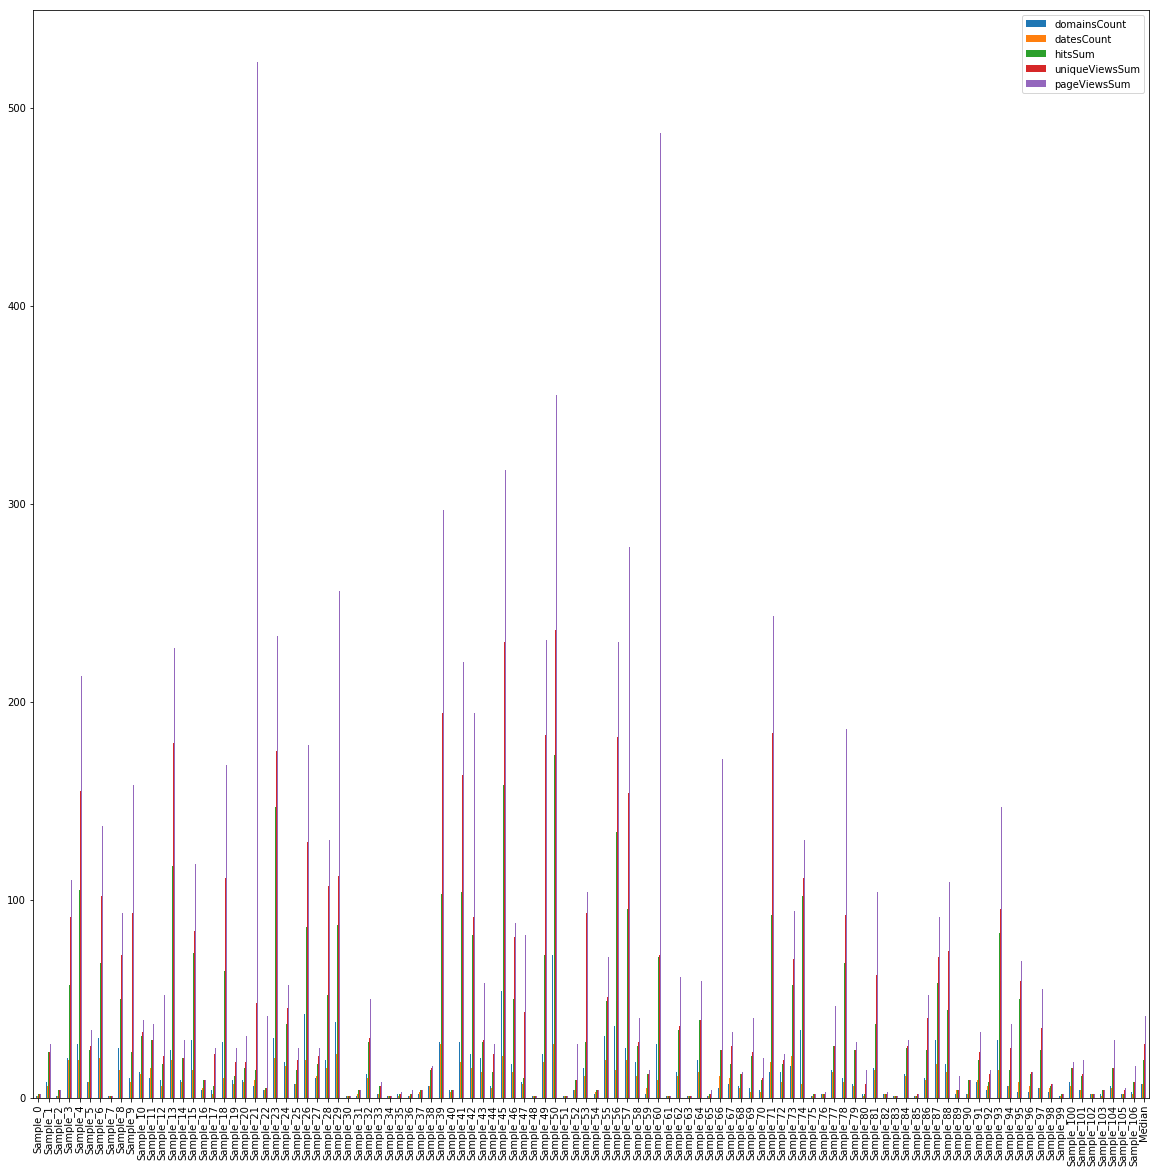

<Figure size 432x288 with 0 Axes>

In [22]:
#Plot graph
samples_for_plot.plot(kind='bar',figsize=(20,20))
plt.xticks(range(sample_size+1),labels)
plt.figure()
plt.show()

- Can see that some accounts have significantly higher activity than others

In [23]:
#For a better comparison, we will look at the heat map of the data
summary_data = samples[summary_metric_cols]
percentiles_summary_data = 100*summary_data.rank(pct=True)

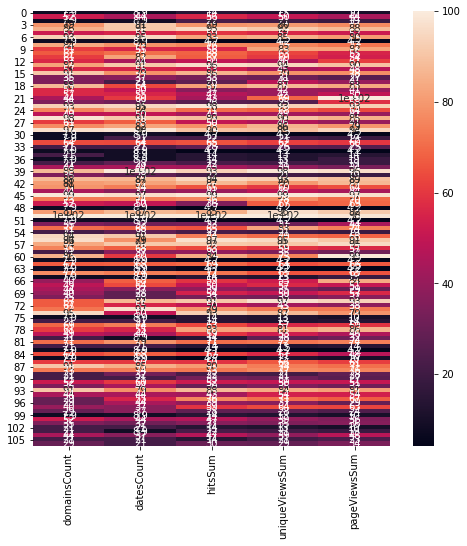

In [24]:
plt.figure(figsize=(8,8))
sns.heatmap(percentiles_summary_data, annot=True)

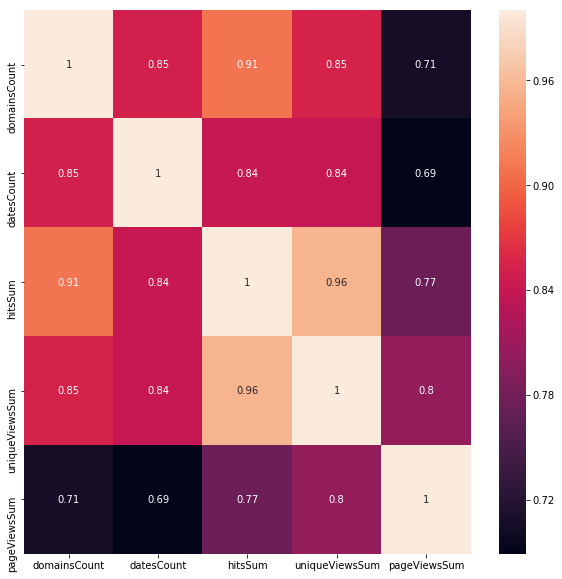

In [25]:
#Correlation heatmap!
plt.figure(figsize=(10,10))
sns.heatmap(summary_data.corr(),annot=True)

In [26]:
#Look at breakdown by IAB Cat
continuous_data = good_data[continuous_cols]
#Expensive operation so run the calculations first and graph seperately
correlations = continuous_data.corr()

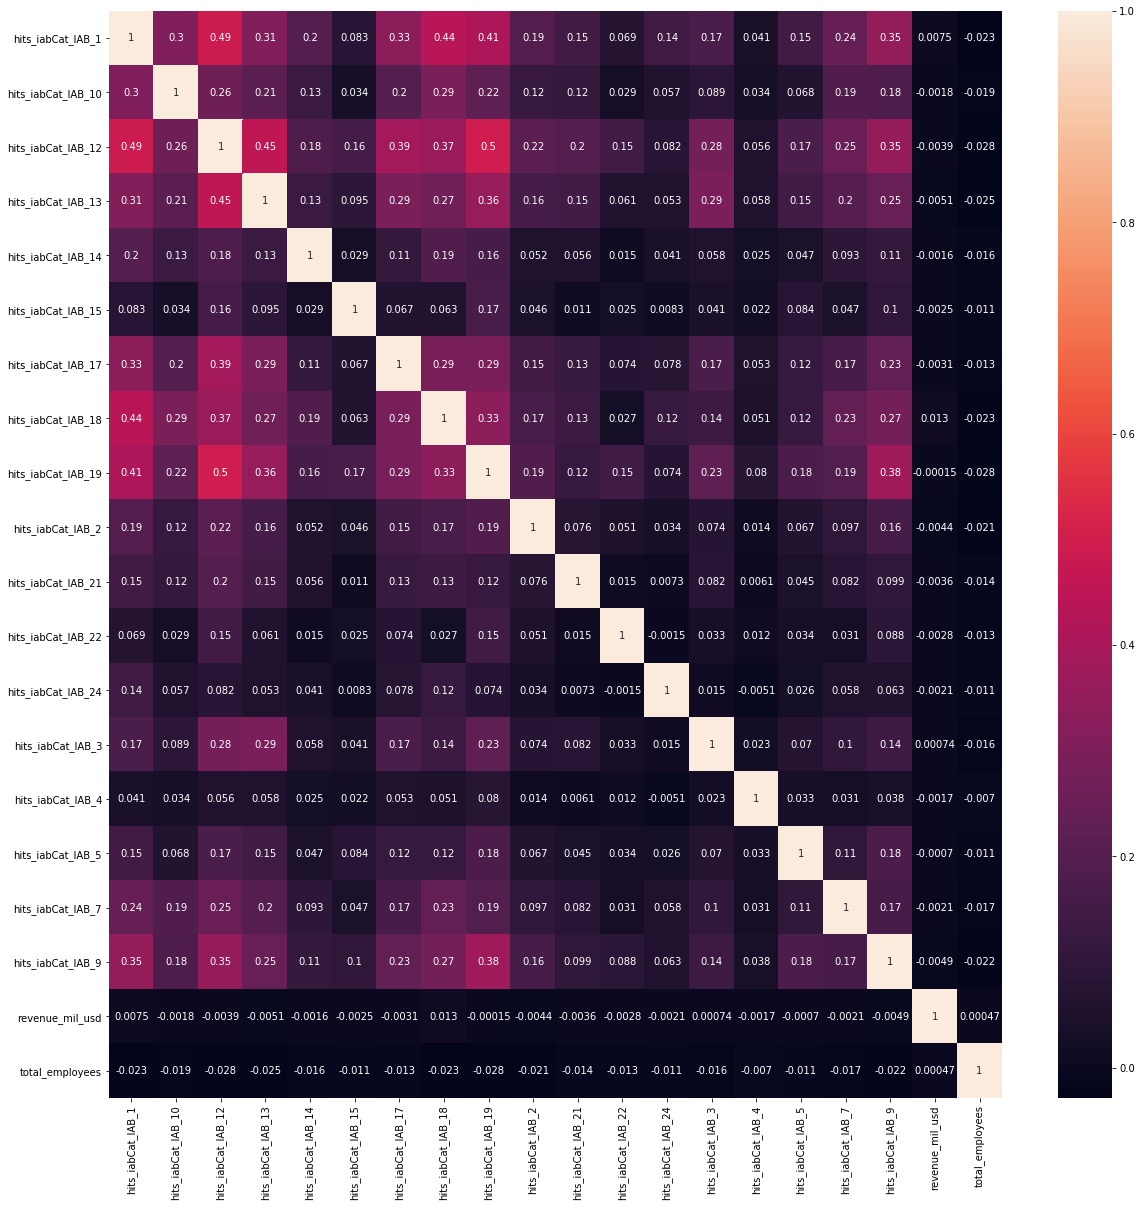

In [27]:
plt.figure(figsize=(20, 20))
sns.heatmap(correlations,annot=True)

- Potential data quality issue with revenue_mil_usd and total_employees. These should be correlated right?

### Predictive Power of Features
Quick analysis to see if there are any clear inference a supervised learning could generate from the data

In [28]:
#Prepare target value (category 19 is what we specialise in selling so lates try this one)
target = 'hits_iabCat_IAB_19'
#Returns a series for all the target values (same as keying a dict in kdb!)
target_data = continuous_data[target]
#Ravel series data as single column target
target_data = target_data.ravel()

#Drop target so we can use a feature
continuous_data.drop([target], axis = 1, inplace = True)
print("Wholesale customers dataset created to predict " + target +  " has {} samples with {} features each.".format(*continuous_data.shape))

Wholesale customers dataset created to predict hits_iabCat_IAB_19 has 21323 samples with 19 features each.


C:\Users\cbath\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
#Split the data into training and testing sets(0.25)
X_train, X_test, y_train, y_test = train_test_split(continuous_data, target_data, test_size=0.25, random_state=10)

#Create a decision tree regressor and fit it to the training set
regressor = tree.DecisionTreeRegressor(max_depth=25)
regressor = regressor.fit(X_train,y_train)
print('DecisionTreeRegressor fit to training data')

# TODO: Report the score of the prediction using the testing set
testPredictions = regressor.predict(X_test)
testPredictions = testPredictions
print('DecisionTreeRegressor test predictions ran')

#Score must be relevant to a regressor(r2 score used)
score = regressor.score(X_test, y_test)
print(score)

DecisionTreeRegressor fit to training data
DecisionTreeRegressor test predictions ran
-0.33926440773153077


- Very poor predictions soley based on IAB Activity trying to predict hits_iabCat_IAB_19.

# Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

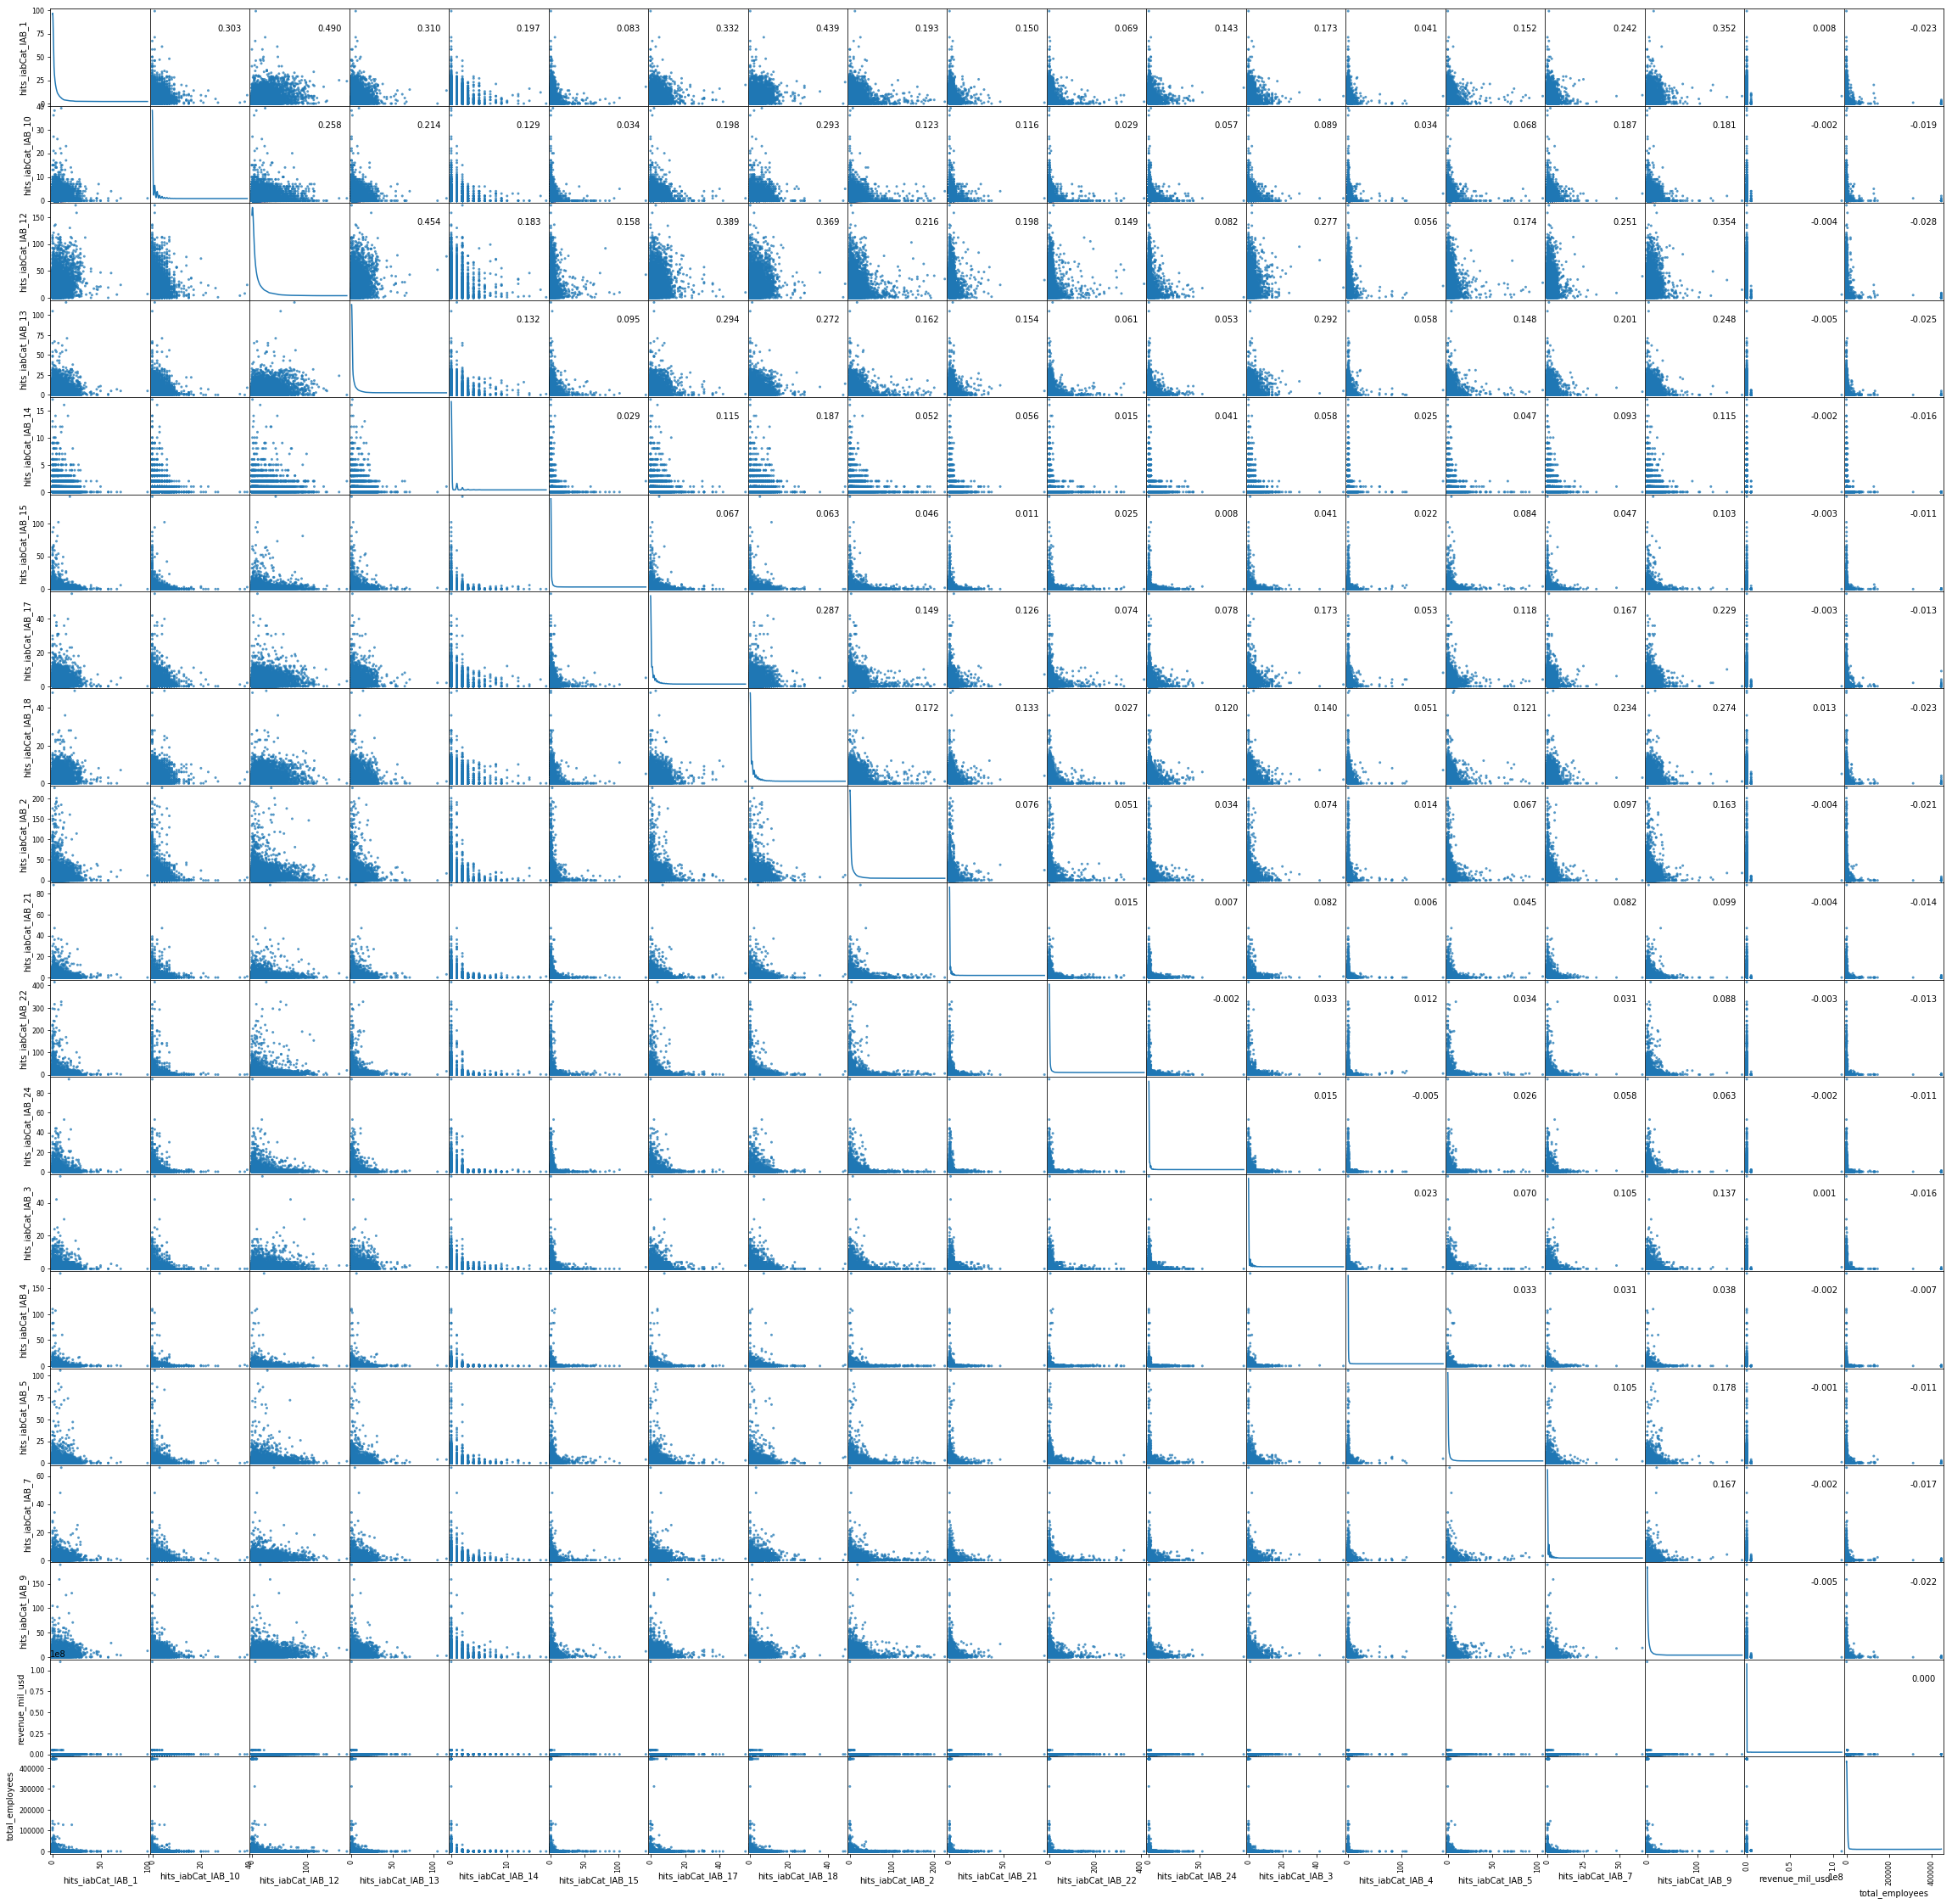

In [30]:
# Produce a scatter matrix for each pair of features in the data
axes = scatter_matrix(continuous_data, alpha=0.75, figsize = (40,40), diagonal = 'kde')
corr = continuous_data.corr().values
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

- All the continuious columns are skewed to the right. Going to need some data conversions here

## Feature Scaling

In [31]:
#Limit to only continuous features
good_data = good_data[continuous_cols]
samples = samples[continuous_cols]
#Scale the data using the natural logarithm
log_data = good_data.apply(lambda x: np.log(x+1))
log_samples = samples.apply(lambda x: np.log(x+1))

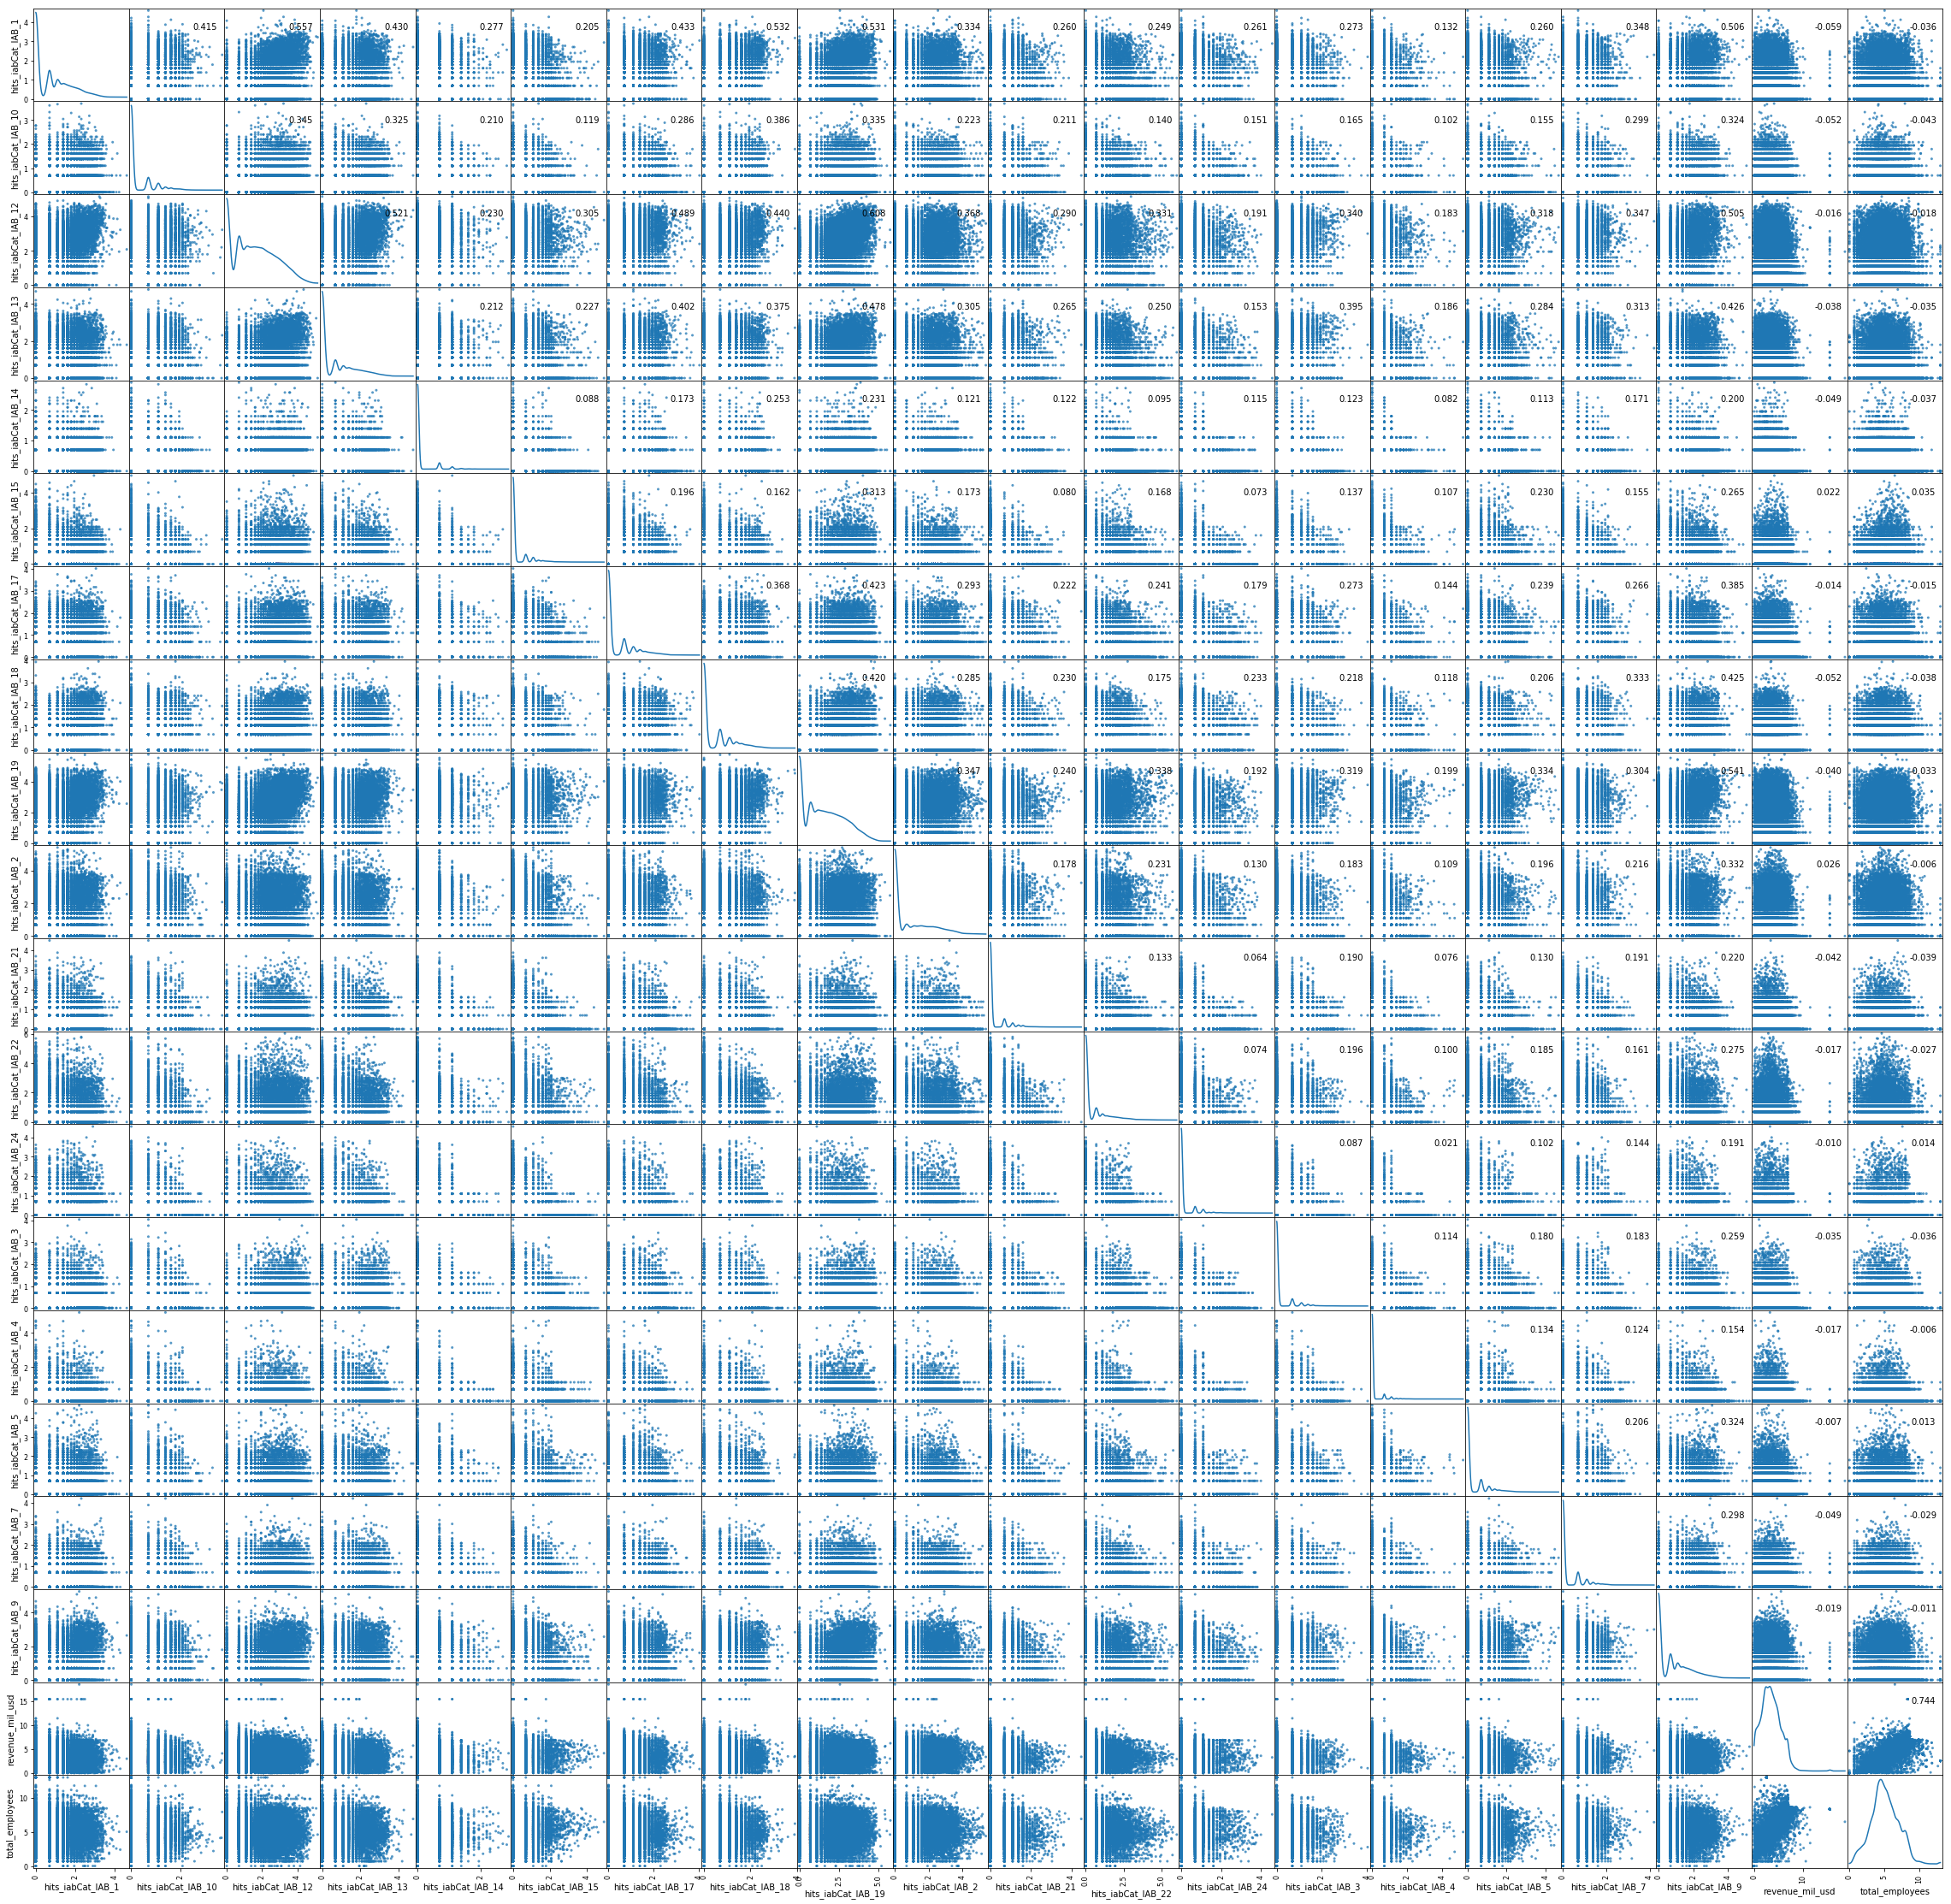

In [32]:
# Produce a scatter matrix for each pair of newly-transformed features
axes = scatter_matrix(log_data, alpha=0.75, figsize = (40,40), diagonal = 'kde')
corr = log_data.corr().values
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

In [33]:
#Not quite normarmally distrubuted for a lot of columns, lets try the boxco transformation
#Another option in that case is the BoxCox transformation. WE CAN'T AS WE HAVE 0 VALUES PRESENT
#boxcox_data = reduced_data.apply(lambda x: boxcox(x)[0])
#pd.scatter_matrix(boxcox_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde');

### Dimensionality Reduction using PCA

array(['hits_iabCat_IAB_1', 'hits_iabCat_IAB_10', 'hits_iabCat_IAB_12',
       'hits_iabCat_IAB_13', 'hits_iabCat_IAB_14', 'hits_iabCat_IAB_15',
       'hits_iabCat_IAB_17', 'hits_iabCat_IAB_18', 'hits_iabCat_IAB_19',
       'hits_iabCat_IAB_2', 'hits_iabCat_IAB_21', 'hits_iabCat_IAB_22',
       'hits_iabCat_IAB_24', 'hits_iabCat_IAB_3', 'hits_iabCat_IAB_4',
       'hits_iabCat_IAB_5', 'hits_iabCat_IAB_7', 'hits_iabCat_IAB_9',
       'revenue_mil_usd', 'total_employees'], dtype=object)

Total dataset components = 20


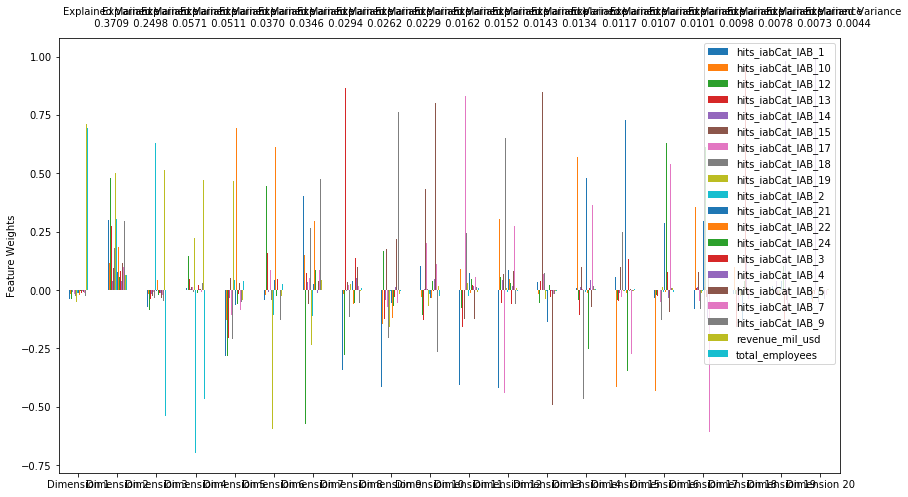

In [34]:
#Apply PCA by fitting the good data with the same number of dimensions as features
components = np.unique(log_data.keys())
componentsN = len(components)
display(components)
pca = PCA(n_components=componentsN).fit(log_data)
print('Total dataset components = ' + str(componentsN))

#Transform the good data using the PCA fit above
reduced_data = pca.transform(log_data)

#Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(log_data, pca)

In [35]:
print(pca_results['Explained Variance'].cumsum())

Dimension 1     0.3709
Dimension 2     0.6207
Dimension 3     0.6778
Dimension 4     0.7289
Dimension 5     0.7659
Dimension 6     0.8005
Dimension 7     0.8299
Dimension 8     0.8561
Dimension 9     0.8790
Dimension 10    0.8952
Dimension 11    0.9104
Dimension 12    0.9247
Dimension 13    0.9381
Dimension 14    0.9498
Dimension 15    0.9605
Dimension 16    0.9706
Dimension 17    0.9804
Dimension 18    0.9882
Dimension 19    0.9955
Dimension 20    0.9999
Name: Explained Variance, dtype: float64


In [36]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, sample_size), columns = pca_results.index.values))

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0       0.895524    -2.098713    -0.142060     0.038615    -0.350206   
1       0.379015     0.363959    -0.637805     0.816194    -0.288318   
2      -0.025588    -1.937239    -0.541407    -0.224262    -0.464773   
3       1.459758     1.988770    -1.137812     0.995682    -0.961273   
4       0.286637     3.109665     0.430268    -1.285606    -0.911855   
5      -1.216717    -0.389932     0.674061     0.711790     0.188072   
6      -1.487449     2.063418    -0.765242    -1.324645     1.294639   
7       1.302888    -2.397850    -0.028455    -0.036821    -0.185766   
8       4.255234     2.503862     0.928610    -0.798123    -0.810760   
9      -1.486224    -0.274340     0.923717    -1.827250    -0.560021   
10     -0.982020     0.572209    -1.370957     0.056772    -0.870764   
11      4.551125     0.680766    -0.202814     0.966249    -0.422159   
12     -3.460989    -0.831562    -0.266912     0.659223     0.022791   
13      0.764788     3.691035    -0.077365     0.368050    -0.214894   
14     -3.746275    -0.172702    -0.463428     0.775857     0.351340   
15     -0.060672     2.506488     0.814227    -0.611220     0.950761   
16     -4.070919    -1.922586    -0.593813     0.153118     1.067833   
17      0.423372    -1.587670     0.545426    -1.111328    -0.220039   
18      3.127138     3.013500     0.285474     0.412387    -0.977897   
19      2.371092    -0.933004    -1.053856    -0.255524     0.272850   
20      0.949302    -0.806261    -0.179275     0.920838     0.850001   
21     -2.662609    -1.440065    -1.279923    -0.783577    -0.352433   
22     -2.720188    -2.023564    -0.063944     0.302991     0.401897   
23     -1.611266     3.362622    -1.150977     1.483837     0.441142   
24     -0.756558     1.358614     0.672020    -0.627978     1.308339   
25      2.771118    -0.008325    -1.148936    -2.014472    -0.553143   
26     -0.659156     3.266854     1.009007     0.841869    -1.574751   
27      1.429083     0.079258    -0.143405     0.029863     0.343996   
28     -1.573660     1.560120     0.351087    -1.548445    -1.629481   
29     -1.763776     2.853483    -1.404473     1.242314    -0.687816   
..           ...          ...          ...          ...          ...   
77      5.154030     0.698571    -2.356711    -1.058924     0.484244   
78      2.816521     1.031001    -1.321021    -0.101858     0.973198   
79     -1.476594    -0.348710    -0.630179     0.281249     0.317442   
80      5.015908    -1.830110    -0.181435     0.015056    -0.332297   
81     -2.311002     1.275703     0.119695     0.329262    -0.002534   
82     -3.265413    -2.784039    -0.238256    -0.319740    -0.195913   
83     -2.631062    -2.744322    -0.094198    -1.108702     0.039231   
84      1.034100     0.199278     0.757394    -0.440358     0.797418   
85      1.539999    -2.234533     0.023051     0.110210    -0.247338   
86     -1.939681    -0.221822    -0.066232    -2.180455     0.097243   
87      0.523072     2.074819     0.060423    -2.081176    -0.470230   
88     -4.399712     1.300828    -0.570612     1.318380     0.174831   
89      1.292534    -1.861548    -0.728698    -0.450653    -0.424057   
90     -2.906762    -1.633300    -0.540028    -0.032667     0.204692   
91      1.899579     0.134098    -0.177554     1.092344    -0.281601   
92     -0.095400    -1.764690     0.524310     0.593050    -0.664523   
93     -4.239094     2.314481    -0.829823     1.548073    -0.474992   
94     -0.486300    -0.533673    -0.761949     0.321916    -0.243836   
95     -1.720061    -0.846728    -0.587917     0.166837     3.326722   
96      3.730100    -0.629190    -0.376470     0.499162    -0.502389   
97      1.831429    -0.773706     0.390297    -0.336999     0.494073   
98      5.553446    -1.138938     0.168990     0.626531    -0.735858   
99     -0.592224    -2.557385     0.988596    -0.100528    -0.050742   
100    -3.954697    -0.700104     0.637630   

In [50]:
#Apply PCA by fitting the good data with only 11 dimensions (based on ~90% of variance explained by 11 components above)
nc = 10
pca = PCA(n_components=nc).fit(log_data)

#Transform the good data using the PCA fit above
reduced_data = pca.transform(log_data)

#Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

#Create a DataFrame for the reduced data
column_names = []
for i in range(1,nc+1):
    name = 'Dimension '+str(i)
    column_names.append(name)
reduced_data = pd.DataFrame(reduced_data, columns = column_names)

In [38]:
# Display sample log-data after applying PCA transformation in two dimensions
#display(reduced_data)

### Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components. In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

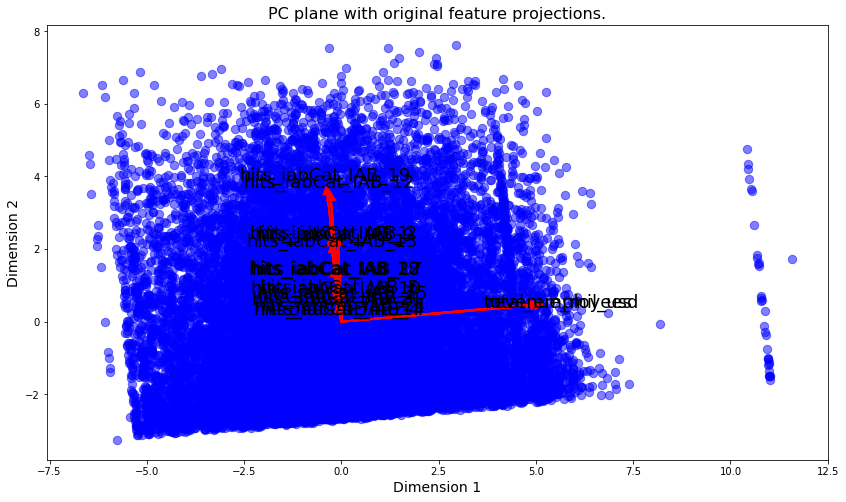

In [51]:
# Create a biplot
vs.biplot(log_data, reduced_data, pca)

## Creating Clusters


In [48]:
#Example https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
clustersN=3
#Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=clustersN,random_state=1).fit(reduced_data)
#Predict the cluster for each data point
preds = clusterer.predict(reduced_data)
#Find the cluster centers (not applicable to DB scan)
centers = clusterer.cluster_centers_ 
#display(centers)

#Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print(score)

0.2498421177332601


### Cluster Visualization


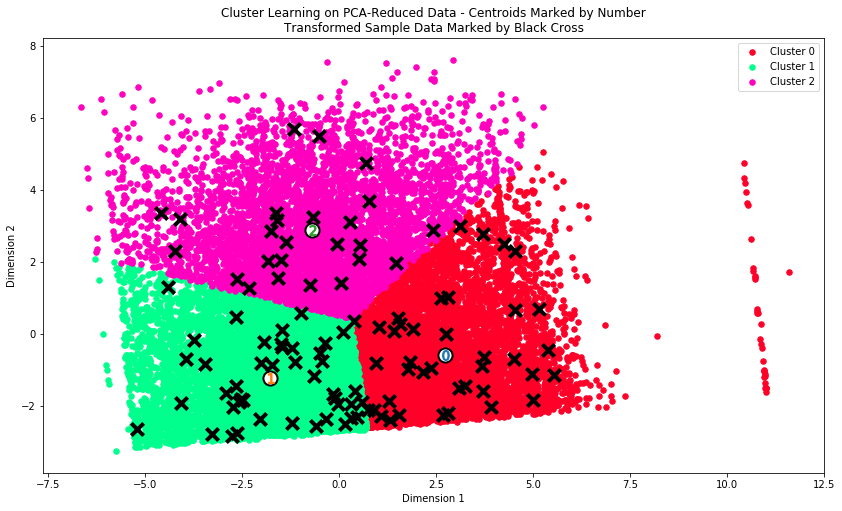

In [46]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Data Recovery
Applying the inverse operations to the data following transformations


In [52]:
#Inverse transform the centers
log_centers = pca.inverse_transform(centers)

#Exponentiate the centers and remove the 1 from earlier (used to prevent log 0 error)
true_centers = np.exp(log_centers) - 1

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = good_data.keys())
true_centers.index = segments
display(true_centers)
true_centers.to_csv('summary_clusters.csv')

hits_iabCat_IAB_1  hits_iabCat_IAB_10  hits_iabCat_IAB_12  \
Segment 0                1.0                 0.0                 2.0   
Segment 1                1.0                 0.0                 2.0   
Segment 2                4.0                 1.0                17.0   

           hits_iabCat_IAB_13  hits_iabCat_IAB_14  hits_iabCat_IAB_15  \
Segment 0                 0.0                 0.0                 0.0   
Segment 1                 0.0                 0.0                 0.0   
Segment 2                 3.0                 0.0                 1.0   

           hits_iabCat_IAB_17  hits_iabCat_IAB_18  hits_iabCat_IAB_19  \
Segment 0                 0.0                 0.0                 2.0   
Segment 1                 0.0                 0.0                 2.0   
Segment 2                 2.0                 2.0                18.0   

           hits_iabCat_IAB_2  hits_iabCat_IAB_21  hits_iabCat_IAB_22  \
Segment 0                1.0                 0.0                 0.0   
Segment 1                1.0                 0.0                 0.0   
Segment 2                4.0                 1.0                 2.0   

           hits_iabCat_IAB_24  hits_iabCat_IAB_3  hits_iabCat_IAB_4  \
Segment 0                 0.0                0.0                0.0   
Segment 1                 0.0                0.0                0.0   
Segment 2                 0.0                1.0                0.0   

           hits_iabCat_IAB_5  hits_iabCat_IAB_7  hits_iabCat_IAB_9  \
Segment 0                0.0                0.0                1.0   
Segment 1                0.0                0.0                0.0   
Segment 2                1.0                1.0                4.0   

           revenue_mil_usd  total_employees  
Segment 0            218.0           1024.0  
Segment 1              7.0             42.0  
Segment 2             22.0            122.0

# Summary & Conclusions
Using k-means to try and determine if there are distinct cluster of companies to be found within this dataset, based on their web activty on website of different categorisations, as per the IAB taxonomy, there appears to be no distinct behaviour of companies. A sillouhette score of 0.19 highlights this along with the clustering visualisation above which clusters with large overlaps.

Next Steps for the Business:
- There are clearly some serious data quality issue here. The business needs to decide if it is worth investing in monitioring any of the blacklisted categories or a decision should be made to stop tracking activity on blacklisted IAB categorised website 

- Click data needs to be increased in order to drive any significant machine learning inferences going forward. Right now we not have significant data accross all accounts. I'd suggest we invest in serving display ads to all companies in our database to be building up a baseline for activity and help drive future analysis.

- There are some serious outliers, which should be taken into consideration with the existing scoring models, as they could skew the entire accounts list. Highly likely they will always bubble to the top of client accounts

Further Analysis:
- Can any inferences be made at a high level of granulairty other than company, e.g. at the country level?
- Hierachal clustering methods to determine the number of clusters